In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import entropy, kruskal, f_oneway, spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re # For parsing proficiency scores
import statsmodels.api as sm
from statsmodels.formula.api import ols
import gensim.models
import scikit_posthocs as sp

In [2]:
# --- Configuration ---
LEAPQ_FILE = 'results_LEAPQ.xlsx'
TOT_FILE = 'results_TOT.xlsx'
ASSOCIATION_FILE = 'results_association.xlsx'

In [3]:
# You need a pre-trained word embedding model for French.
# Download one (e.g., from fastText: https://fasttext.cc/docs/en/crawl-vectors.html)
# and update the path below.
# Example using gensim downloader (requires internet connection first time):
#import gensim.downloader as api
#model_path = api.load('fasttext-fr-300d-1M', return_path=True) # Example model
# Or provide a direct path to the downloaded file:
# Replace this path with the ACTUAL path where you saved the downloaded file
WORD_EMBEDDING_MODEL_PATH = '/Users/borghesani/Documents/5_Students/UNIGE_master_students/Lina_Languer/cc.fr.300.bin' # or .bin
LOAD_EMBEDDINGS = True # Set to False if you don't have a model or want to skip this part

In [4]:
def parse_proficiency(prof_str):
    """
    Parses the proficiency string (e.g., "9,7,5,3") into a list of floats.
    Handles potential non-numeric characters or formatting issues.
    """
    if pd.isna(prof_str):
        return []
    # Remove any non-numeric characters except comma and decimal point
    cleaned_str = re.sub(r'[^\d,.]', '', str(prof_str))
    try:
        # Split and convert to float, filtering out empty strings
        scores = [float(s.strip()) for s in cleaned_str.split(',') if s.strip()]
        # Ensure scores are positive for log transformation
        scores = [max(s, 1e-9) for s in scores] # Add small epsilon to avoid log(0)
        return scores
    except ValueError:
        print(f"Warning: Could not parse proficiency string: {prof_str}")
        return []

In [5]:
def calculate_mlp(proficiency_data):
    """
    Calculates the Multilingual Proficiency (MLP) score using entropy.
    Handles empty lists, single language cases, and ensures scores are positive.
    Args:
        proficiency_data: A list of positive proficiency scores for each language.
    Returns:
        The MLP score (entropy), or 0 if calculation is not possible.
    """
    if not proficiency_data or len(proficiency_data) == 0:
        return 0.0 # No languages or invalid data

    # Ensure all scores are positive floats
    proficiency_data = [float(max(score, 1e-9)) for score in proficiency_data]

    if len(proficiency_data) == 1:
         # Entropy is 0 for a single language, regardless of proficiency level
         # Represents minimal language diversity.
        return 0.0

    # Log-transform proficiency scores (already ensured positive)
    log_proficiency = np.log(proficiency_data)

    # Calculate the proportion of log-proficiency for each language
    # Use absolute value to handle cases where sum might be negative if scores < 1
    total_log_proficiency = np.sum(log_proficiency)

    if abs(total_log_proficiency) < 1e-9:
         # Avoid division by zero if all scores were 1 (log(1)=0)
         # Assign uniform probability if all log scores are zero
         proportions = np.ones(len(proficiency_data)) / len(proficiency_data)
    else:
         # Normalize log proficiencies to get proportions
         # Note: This normalization differs from standard entropy calculation which uses raw probabilities.
         # This specific method aims to capture proficiency *distribution*.
         # Consider if standard entropy on raw scores (normalized) is more appropriate.
         # proportions = np.array(proficiency_data) / np.sum(proficiency_data) # Standard approach
         proportions = log_proficiency / total_log_proficiency # Method based on user's original idea

         # Ensure proportions are non-negative and sum close to 1 (handle potential floating point issues)
         proportions = np.maximum(proportions, 0)
         proportions /= np.sum(proportions)

    # Calculate entropy (using base e, as specified by base=None)
    mlp_score = entropy(proportions, base=None)

    return mlp_score

    # Normalize MLP score by the maximum possible entropy (log N) ==== NOT SURE IF WE WANT TO DO THIS NORMALIZATION
    # This makes the score range roughly between 0 and 1
    #max_entropy = np.log(len(proficiency_data))
    #if max_entropy > 0:
        #normalized_mlp = mlp_score / max_entropy
        #return normalized_mlp
    #else:
        #return 0.0 # Should only happen if len is 1, already handled, but for safety.

In [6]:
def calculate_semantic_distance(target, associates, model):
    """
    Calculates the average cosine distance between a target word and its associates
    using the standard Gensim API. Handles words potentially not in the vocabulary.

    Args:
        target (str): The target word.
        associates (list): A list of associated words (strings).
        model: A loaded gensim KeyedVectors model (e.g., from load_facebook_vectors).

    Returns:
        The average cosine distance, or np.nan if calculation fails
        (e.g., target not usable, or no valid associates found in the model).
    """
    # --- Input Validation ---
    if pd.isna(target) or not isinstance(target, str) or not associates:
        return np.nan

    # Clean associate list (remove potential NaNs or non-strings if list comes from pandas)
    associates = [word for word in associates if isinstance(word, str) and pd.notna(word)]
    if not associates:
        return np.nan

    # --- Check Target Word ---
    # Use 'in' operator - the standard way to check vocabulary presence
    # For FastText, this checks the known vocabulary learned during training.
    # It does NOT check if an OOV vector *could* be generated.
    if target not in model:
        # print(f"Warning: Target word '{target}' not in model vocabulary.")
        return np.nan

    # --- Calculate Distances ---
    distances = []
    for assoc in associates:
        # Use 'in' operator for associates too
        if assoc in model:
            try:
                # Use the built-in model.similarity method.
                # It's efficient and handles vector normalization.
                # For FastText, this uses vectors from the known vocabulary.
                similarity = model.similarity(target, assoc)

                # Cosine distance = 1 - similarity
                distance = 1.0 - similarity
                distances.append(distance)

            except KeyError:
                # This is a safeguard, model.similarity might raise KeyError
                # if a word passed the 'in' check but somehow isn't retrievable.
                # print(f"Warning: Could not compute similarity between '{target}' and '{assoc}'.")
                pass # Skip this associate
        # else:
            # print(f"Warning: Associate word '{assoc}' for target '{target}' not in model vocabulary.")
            # Skip associate if not in model (implicit from the 'if assoc in model' check)

    # --- Return Result ---
    if not distances:
        # This happens if the target was found, but none of its valid associates were.
        # print(f"Warning: Target '{target}' found, but none of its valid associates were in the model vocabulary.")
        return np.nan

    return np.mean(distances)

In [7]:
# --- 1. Load Data ---
print("Loading data...")
try:
    df_leapq = pd.read_excel(LEAPQ_FILE)
    df_tot = pd.read_excel(TOT_FILE)
    df_association = pd.read_excel(ASSOCIATION_FILE)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure the Excel files (results_LEAPQ.xlsx, results_TOT.xlsx, results_association.xlsx) are in the correct directory.")
    exit() # Exit if files are not found

# --- Data Cleaning and Preparation ---
# Clean column names (remove leading/trailing spaces, replace spaces with underscores)
def clean_col_names(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[^A-Za-z0-9_]+', '', regex=True)
    return df

df_leapq = clean_col_names(df_leapq)
df_tot = clean_col_names(df_tot)
df_association = clean_col_names(df_association)

# Ensure Participant_ID is the same type for merging (string or int)
df_leapq['Participant_ID'] = df_leapq['Participant_ID'].astype(str)
df_tot['Participant_ID'] = df_tot['Participant_ID'].astype(str)
df_association['Participant_ID'] = df_association['Participant_ID'].astype(str)

print("Data cleaned and prepared")

Loading data...
Data loaded successfully.
Data cleaned and prepared


In [8]:
# --- 2. Demographic Table ---
print("\n--- Demographic Summary ---")
mean_age = df_leapq['Age'].mean()
std_age = df_leapq['Age'].std()
min_age = df_leapq['Age'].min()
max_age = df_leapq['Age'].max()
gender_counts = df_leapq['Sex'].value_counts(normalize=True) * 100
mean_languages = df_leapq['Number_of_Languages'].mean()
std_languages = df_leapq['Number_of_Languages'].std()
total_participants = len(df_leapq)

print(f"Total Participants: {total_participants}")
print(f"Age: Mean={mean_age:.2f}, SD={std_age:.2f}, Range=({min_age}-{max_age})")
print("Gender Distribution:")
print(gender_counts.to_string())
print(f"Number of Languages Spoken: Mean={mean_languages:.2f}, SD={std_languages:.2f}")


--- Demographic Summary ---
Total Participants: 35
Age: Mean=24.23, SD=7.00, Range=(19-46)
Gender Distribution:
Sex
F    77.142857
M    22.857143
Number of Languages Spoken: Mean=4.31, SD=1.30


In [9]:
# --- 3. MLP Calculation ---
print("\nCalculating MLP scores...")
# Assuming the proficiency scores are in a column named 'Proficiency' based on PDF structure
# If the column name is different in your Excel file, change 'Proficiency' below.
if 'Proficiency' in df_leapq.columns:
    df_leapq['Proficiency_Scores'] = df_leapq['Proficiency'].apply(parse_proficiency)
    df_leapq['MLP'] = df_leapq['Proficiency_Scores'].apply(calculate_mlp)
    print("MLP scores calculated.")
    print(df_leapq[['Participant_ID', 'Proficiency', 'MLP']].head())
else:
    print("Warning: 'Proficiency' column not found in LEAPQ data. Skipping MLP calculation.")
    df_leapq['MLP'] = np.nan # Add MLP column with NaNs


Calculating MLP scores...
MLP scores calculated.
  Participant_ID  Proficiency       MLP
0          10973     10,6,8,6  1.380548
1          10974       10,9,7  1.096159
2          10975  10,10,8,6,4  1.593105
3          10979       10,8,7  1.096193
4          10980        7,9,7  1.096931


In [10]:
# --- 4. Merge Data ---
print("\nMerging datasets...")
# Use the Score from the association task (trial-level)
df_merged = pd.merge(df_association, df_leapq, on='Participant_ID', how='left')
# We might not need df_tot if df_association['Score'] is the primary variable
# df_merged = pd.merge(df_merged, df_tot, on='Participant_ID', how='left') # Optional: if TOT summary needed

# Extract associate words into a list for semantic distance calculation
assoc_cols = [col for col in df_merged.columns if col.startswith('Word_')]
df_merged['Associates'] = df_merged[assoc_cols].apply(lambda row: row.dropna().tolist(), axis=1)

print("Datasets merged.")
print(f"Merged DataFrame shape: {df_merged.shape}")
print(df_merged.head())


Merging datasets...
Datasets merged.
Merged DataFrame shape: (1573, 25)
  Participant_ID Target_Word  Score  Number_of_Associate    Word_1     Word_2  \
0          10973   accordeon      4                    5     piano  mouvement   
1          10973      agrafe      4                    7    outils   feuilles   
2          10973    arbalete      3                    6  arbalète        Arc   
3          10973     asperge      3                    7    patate     légume   
4          10973    autruche      1                    4    Coulon     animal   

     Word_3     Word_4   Word_5  Word_6  ... Word_12 Age  \
0  ensemble    musique  chanter     NaN  ...     NaN  20   
1    utiles      école  travail  bureau  ...     NaN  20   
2     tirer  précision      roi   force  ...     NaN  20   
3    manger      santé     vert   santé  ...     NaN  20   
4   méchant        fin      NaN     NaN  ...     NaN  20   

                         All_Languages Number_of_Languages Mother_Tongue Sex  \


--- Analysis 1: Number of Associates vs. ToT Score (Scores 3 & 4 Merged) ---
Merged Score category 4 into 3.

Mean Number of Associates per Score (Scores 3 & 4 merged):
                  mean       std  count
Score_Factor                           
1             5.264249  1.889854    386
2             5.050000  1.925960     60
3             4.393079  1.872695   1127

Kruskal-Wallis Test (Number of Associates vs. Merged Score): H=56.483, p=5.43e-13
Significant difference found between groups.

Using custom colors: ['skyblue', 'lightcoral', 'lightgreen']


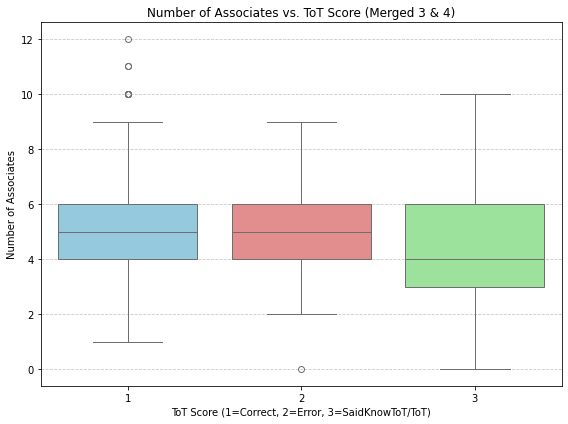

In [11]:
# --- 5. Hypothesis 1: Number of Associates vs. ToT Score (Modified) ---
print("\n--- Analysis 1: Number of Associates vs. ToT Score (Scores 3 & 4 Merged) ---")

# Check if 'Number_of_Associate' and 'Score' columns exist
required_cols_h1 = ['Number_of_Associate', 'Score']
if not all(col in df_merged.columns for col in required_cols_h1):
    print(f"Error: Required columns {required_cols_h1} not found in the merged data. Check column names.")
else:
    # Create a copy to avoid modifying the original df_merged if needed elsewhere
    df_analysis_h1 = df_merged[required_cols_h1].copy()

    # Remove rows with NaN scores or associates if any
    df_analysis_h1 = df_analysis_h1.dropna(subset=['Score', 'Number_of_Associate'])

    # Convert Score to integer type first (important before comparison/replacement)
    try:
        df_analysis_h1['Score'] = df_analysis_h1['Score'].astype(int)
    except ValueError:
        print("Warning: Could not convert 'Score' column to integer. Check data.")
        # Handle error or exit if conversion is critical and cannot proceed
        df_analysis_h1 = pd.DataFrame() # Clear dataframe to prevent further errors

if not df_analysis_h1.empty: # Proceed only if data is valid

    # --- MODIFICATION 1: Merge Score 4 into Score 3 ---
    # Replace all occurrences of score 4 with 3
    df_analysis_h1['Score'] = df_analysis_h1['Score'].replace(4, 3)
    print("Merged Score category 4 into 3.")

    # Create categorical variable for plotting/stats
    # Ensure categories are correctly ordered after merging (will now be 1, 2, 3)
    unique_scores = sorted(df_analysis_h1['Score'].unique())
    df_analysis_h1['Score_Factor'] = pd.Categorical(df_analysis_h1['Score'], categories=unique_scores, ordered=True)

    # Descriptive Statistics
    print("\nMean Number of Associates per Score (Scores 3 & 4 merged):")
    # Use the modified 'Score' or 'Score_Factor' for grouping
    mean_associates = df_analysis_h1.groupby('Score_Factor')['Number_of_Associate'].agg(['mean', 'std', 'count'])
    print(mean_associates)

    # Statistical Test (Kruskal-Wallis H test)
    # Groups are now based on the modified scores (1, 2, 3)
    score_groups = [df_analysis_h1['Number_of_Associate'][df_analysis_h1['Score'] == score]
                    for score in sorted(df_analysis_h1['Score'].unique())]

    # Check if all groups have data and there's more than one group before running the test
    if all(len(group) > 0 for group in score_groups) and len(score_groups) > 1:
        try:
            stat, p_value = kruskal(*score_groups)
            print(f"\nKruskal-Wallis Test (Number of Associates vs. Merged Score): H={stat:.3f}, p={p_value:.3g}")
            if p_value < 0.05:
                print("Significant difference found between groups.")
                # Post-hoc tests (e.g., Dunn's test) would be needed to see which groups differ.
            else:
                print("No significant difference found between groups.")
        except ValueError as e:
             print(f"Could not perform Kruskal-Wallis test: {e}") # Should be less likely now
    else:
        print("\nCould not perform Kruskal-Wallis test: Not enough groups or some groups are empty after merging/filtering.")


    # Plotting
    plt.figure(figsize=(8, 6))

    # --- MODIFICATION 2: Manually specify colors ---
    # Define your desired colors here - one for each remaining score category (1, 2, 3).
    # Replace these examples with your actual color choices.
    # You can use color names ('red', 'blue'), hex codes ('#FF5733'), RGB tuples, etc.
    # Ensure the order matches the order of your categories (1, 2, 3).
    custom_colors = ['#F2B373', '#F2E6FD', '#ECF0FE'] # Example colors for Score 1, Score 2, Score 3(merged)
    custom_colors = ['skyblue', 'lightcoral', 'lightgreen']

    # Check if the number of colors matches the number of categories
    n_categories = len(df_analysis_h1['Score_Factor'].cat.categories)
    if len(custom_colors) == n_categories:
        palette_to_use = custom_colors
        print(f"\nUsing custom colors: {custom_colors}")
    else:
         print(f"\nWarning: Number of custom colors ({len(custom_colors)}) does not match number of score categories ({n_categories}). Using default palette.")
         palette_to_use = 'colorblind' # Fallback to a default palette

    sns.boxplot(data=df_analysis_h1, x='Score_Factor', y='Number_of_Associate', palette=palette_to_use)
    plt.title('Number of Associates vs. ToT Score (Merged 3 & 4)')

    # --- Update X-axis label to reflect merged categories ---
    plt.xlabel('ToT Score (1=Correct, 2=Error, 3=SaidKnowToT/ToT)')
    plt.ylabel('Number of Associates')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping analysis due to data issues (missing columns, NaN values, or conversion error).")

In [12]:
LOAD_EMBEDDINGS = True

In [ ]:
# --- 6. Hypothesis 2: Semantic Distance vs. ToT Score (Modified) ---
print("\n--- Analysis 2: Semantic Distance vs. ToT Score (Scores 3 & 4 Merged) ---")

if LOAD_EMBEDDINGS:
    try:
        # Check if the semantic distance column already exists; if not, calculate it
        if 'Semantic_Distance' not in df_merged.columns:
            print(f"Loading word embedding model from: {WORD_EMBEDDING_MODEL_PATH}...")
            # Choose the appropriate loading method for your model:
            # word_model = KeyedVectors.load_word2vec_format(WORD_EMBEDDING_MODEL_PATH, binary=True) # For Word2Vec .bin
            # word_model = KeyedVectors.load_word2vec_format(WORD_EMBEDDING_MODEL_PATH, binary=False) # For Word2Vec .vec/.txt
            word_model = gensim.models.fasttext.load_facebook_vectors(WORD_EMBEDDING_MODEL_PATH) # For FastText .bin
            # word_model = KeyedVectors.load(WORD_EMBEDDING_MODEL_PATH) # For gensim native format
            print("Word embedding model loaded successfully.")

            # Calculate semantic distance for each row
            print("Calculating semantic distances...")
            df_merged['Semantic_Distance'] = df_merged.apply(
                lambda row: calculate_semantic_distance(row.get('Target_Word'), row.get('Associates'), word_model),
                axis=1
            )
            print("Semantic distances calculated.")
            # Optional: Display some results
            # print(df_merged[['Participant_ID', 'Target_Word', 'Score', 'Associates', 'Semantic_Distance']].head())
        else:
             print("Semantic_Distance column already exists. Using existing data.")

        # --- Analysis Part ---
        # Check if 'Semantic_Distance' and 'Score' columns exist and contain data
        required_cols_h2 = ['Semantic_Distance', 'Score']
        if not all(col in df_merged.columns for col in required_cols_h2):
             print(f"Error: Required columns {required_cols_h2} not found after calculation attempt.")
        else:
            # Create a copy for analysis, including necessary columns
            df_analysis_h2 = df_merged[required_cols_h2].copy()

            # Drop rows with NaN scores or semantic distances
            df_analysis_h2 = df_analysis_h2.dropna(subset=['Score', 'Semantic_Distance'])

            # Convert Score to integer type
            try:
                df_analysis_h2['Score'] = df_analysis_h2['Score'].astype(int)
            except ValueError:
                print("Warning: Could not convert 'Score' column to integer in H2. Check data.")
                df_analysis_h2 = pd.DataFrame() # Clear df to prevent further errors

            if not df_analysis_h2.empty: # Proceed only if data is valid

                # *** MODIFICATION 1: Merge Score 4 into Score 3 ***
                df_analysis_h2['Score'] = df_analysis_h2['Score'].replace(4, 3)
                print("Merged Score category 4 into 3 for semantic distance analysis.")

                # Create categorical variable for plotting/stats
                unique_scores_h2 = sorted(df_analysis_h2['Score'].unique())
                df_analysis_h2['Score_Factor'] = pd.Categorical(df_analysis_h2['Score'], categories=unique_scores_h2, ordered=True)

                # Descriptive Statistics
                print("\nMean Semantic Distance per Score (Scores 3 & 4 merged):")
                mean_distance = df_analysis_h2.groupby('Score_Factor')['Semantic_Distance'].agg(['mean', 'std', 'count'])
                print(mean_distance)

                # Statistical Test (Kruskal-Wallis)
                score_groups_dist = [df_analysis_h2['Semantic_Distance'][df_analysis_h2['Score'] == score]
                                     for score in sorted(df_analysis_h2['Score'].unique())]

                # Check if all groups have data and there's more than one group
                if all(len(group) > 0 for group in score_groups_dist) and len(score_groups_dist) > 1:
                    try:
                        stat_dist, p_value_dist = kruskal(*score_groups_dist)
                        print(f"\nKruskal-Wallis Test (Semantic Distance vs. Merged Score): H={stat_dist:.3f}, p={p_value_dist:.3g}")
                        if p_value_dist < 0.05:
                            print("Significant difference found between groups.")
                        else:
                            print("No significant difference found between groups.")
                    except ValueError as e:
                         print(f"Could not perform Kruskal-Wallis test: {e}")
                else:
                    print("\nCould not perform Kruskal-Wallis test: Not enough groups or some groups are empty after merging/filtering.")


                # Plotting
                plt.figure(figsize=(8, 6))

                # *** MODIFICATION 2: Manually specify colors ***
                # Use the same colors as Analysis 1 for consistency, or define new ones.
                # Ensure the order matches categories (1, 2, 3).
                custom_colors = ['skyblue', 'lightcoral', 'lightgreen'] # Example - REPLACE with your colors

                # Check if the number of colors matches the number of categories
                n_categories_h2 = len(df_analysis_h2['Score_Factor'].cat.categories)
                if len(custom_colors) == n_categories_h2:
                    palette_to_use = custom_colors
                    print(f"\nUsing custom colors: {custom_colors}")
                else:
                    print(f"\nWarning: Number of custom colors ({len(custom_colors)}) does not match number of score categories ({n_categories_h2}). Using fallback palette 'viridis'.")
                    palette_to_use = 'viridis' # Fallback palette

                sns.boxplot(data=df_analysis_h2, x='Score_Factor', y='Semantic_Distance', palette=palette_to_use)

                # *** Update Title and X-axis label ***
                plt.title('Average Semantic Distance vs. ToT Score (Merged 3 & 4)')
                plt.xlabel('ToT Score (1=Correct, 2=Error, 3=SaidKnowToT/ToT)')
                plt.ylabel('Average Cosine Distance (Target vs. Associates)') # Or other distance metric used
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

            else:
                 print("Skipping semantic distance analysis plotting/stats due to data issues (NaNs or conversion error).")

    except FileNotFoundError:
        print(f"Error: Word embedding model file not found at {WORD_EMBEDDING_MODEL_PATH}")
        print("Skipping semantic distance analysis.")
        LOAD_EMBEDDINGS = False # Prevent further errors if logic depends on this
        if 'Semantic_Distance' not in df_merged.columns: df_merged['Semantic_Distance'] = np.nan # Ensure column exists
    except ImportError as e:
        print(f"Error: Required library not installed (likely 'gensim'). {e}")
        print("Please install it (`pip install gensim`). Skipping semantic distance analysis.")
        LOAD_EMBEDDINGS = False
        if 'Semantic_Distance' not in df_merged.columns: df_merged['Semantic_Distance'] = np.nan
    except Exception as e:
        print(f"An unexpected error occurred during semantic distance processing: {e}")
        LOAD_EMBEDDINGS = False
        if 'Semantic_Distance' not in df_merged.columns: df_merged['Semantic_Distance'] = np.nan

else: # if LOAD_EMBEDDINGS is False from the start
    print("Skipping semantic distance analysis as LOAD_EMBEDDINGS is False.")
    # Ensure the column exists with NaNs if other parts of the code might expect it
    if 'Semantic_Distance' not in df_merged.columns:
        df_merged['Semantic_Distance'] = np.nan



--- Analysis 2: Semantic Distance vs. ToT Score (Scores 3 & 4 Merged) ---
Loading word embedding model from: /Users/borghesani/Documents/5_Students/UNIGE_master_students/Lina_Languer/cc.fr.300.bin...


Globally merged Score category 4 (Don't Know) into 3 (ToT) as 'Score_Merged'. Original 'Score' column retained if needed.
--- Data Loaded and Basic Preparation Done ---

--- Analysis for Hypothesis 1: ToT Frequency vs. Multilingualism Measures ---

Descriptive Statistics for H1 (Participant Level):
       Number_of_Languages        MLP  ToT_Frequency
mean              4.314286   1.379449       0.245991
std               1.300937   0.272048       0.177171
min               2.000000   0.691850       0.000000
max               7.000000   1.788733       0.769231
count            35.000000  35.000000      35.000000

--- H1 Correlations ---
Spearman Corr (ToT Freq vs. Num Languages): rho=-0.269, p=0.118
Spearman Corr (ToT Freq vs. MLP Score):       rho=-0.214, p=0.217
Spearman Corr (Num Languages vs. MLP Score): rho=0.945, p=1.55e-17


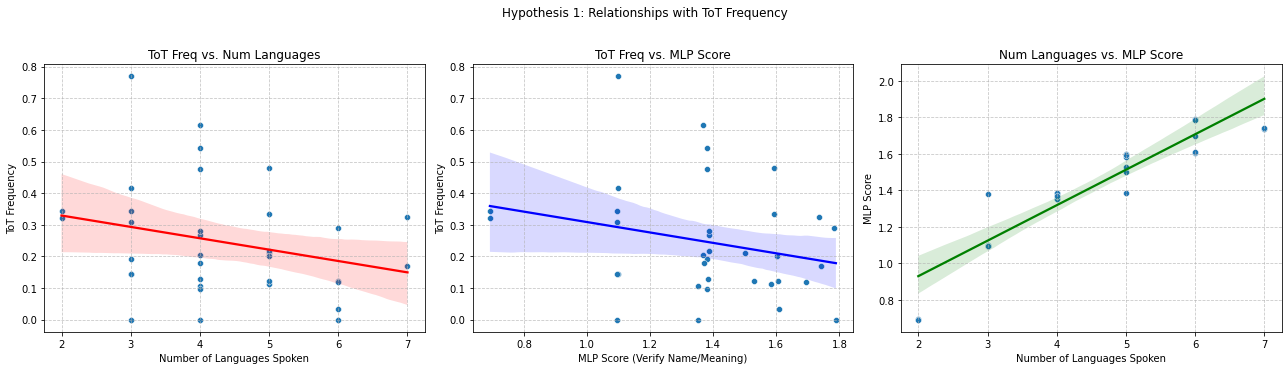


--- Analysis: Score Distribution vs. MLP Score ---
Binning continuous MLP_Score into 3 groups.

Mean counts of each score type per MLP group:
            Score 1 (Correct)  Score 2 (Error)  Score 3 (ToT/DN)
MLP_Group                                                       
Low MLP              9.500000         0.916667         25.583333
Medium MLP          13.090909         2.000000         34.454545
High MLP            10.666667         2.166667         35.416667


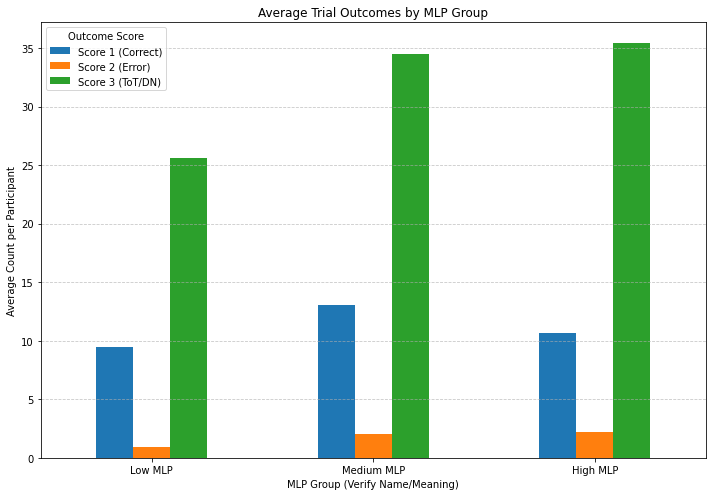


--- Analysis for Hypothesis 2: Number of Associates vs. ToT Score (Merged 3 & 4) ---

Mean Number of Associates per Score (Merged 3 & 4):
                  mean       std  count
Score_Factor                           
1             5.264249  1.889854    386
2             5.135593  1.823767     59
3             4.456346  1.809791   1111

Kruskal-Wallis Test (Number of Associates vs. Merged Score): H=52.189, p=4.65e-12
Significant difference found between groups (H2). Consider post-hoc tests.


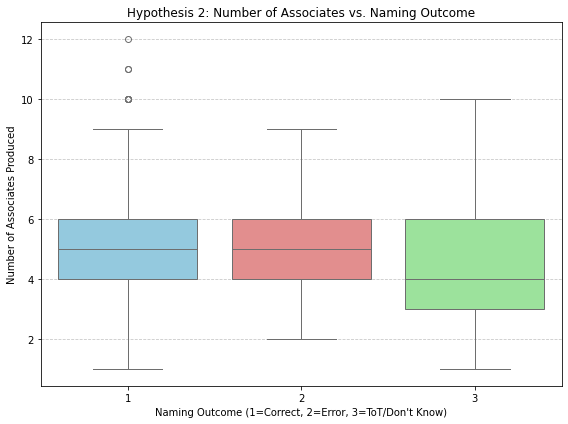


--- Analysis for Hypothesis 3: Semantic Distance vs. ToT Score (Merged 3 & 4) ---

Mean Semantic Distance per Score (Merged 3 & 4):
                  mean       std  count
Score_Factor                           
1             0.710767  0.089824    386
2             0.712769  0.088112     59
3             0.717217  0.097160   1111

Kruskal-Wallis Test (Semantic Distance vs. Merged Score): H=5.099, p=0.0781
No significant difference found between groups (H3).


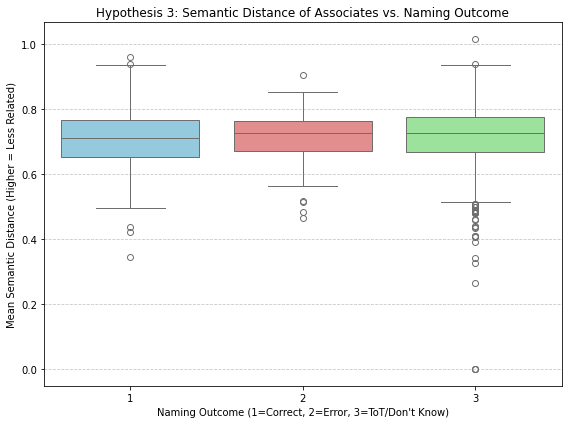


--- All Analyses Attempted ---


In [15]:
# --- Basic Data Cleaning (Example - adapt as needed) ---
# Added MLP_Score to required columns
required_cols = ['Participant_ID', 'Score', 'Number_of_Associate', 'Semantic_Distance', 'Number_of_Languages', 'MLP']
if not all(col in df_merged.columns for col in required_cols):
    missing = [col for col in required_cols if col not in df_merged.columns]
    print(f"Error: Missing one or more required columns: {missing}. Please check your DataFrame.")
    # Exit or handle error appropriately
    exit() # Or raise an error

# Convert relevant columns to numeric, handling potential errors
for col in ['Score', 'Number_of_Associate', 'Semantic_Distance', 'Number_of_Languages', 'MLP']:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# Drop rows where essential numeric data is missing after conversion
df_merged = df_merged.dropna(subset=required_cols)

# --- Merge score 4 into 3 globally for consistency ---
# Do this early so all analyses use the same merged score definition
df_merged['Score_Merged'] = df_merged['Score'].replace(4, 3)
print("Globally merged Score category 4 (Don't Know) into 3 (ToT) as 'Score_Merged'. Original 'Score' column retained if needed.")

print("--- Data Loaded and Basic Preparation Done ---")

# --- 1. Hypothesis 1: ToT Frequency vs. Multilingualism (Num Languages & MLP Score) ---
# H1 (original): ToT frequency increases with the number of languages spoken.
# Added check: Relationship between ToT freq and MLP Score, and between Num Lang and MLP Score.
print("\n--- Analysis for Hypothesis 1: ToT Frequency vs. Multilingualism Measures ---")

# Define which original score represents a ToT state
tot_score_value = 3 # Assuming Score=3 is ToT in the *original* score column

# Calculate total number of relevant trials per participant
trials_per_participant = df_merged.groupby('Participant_ID').size()

# Calculate number of ToT trials per participant using the *original* score
tot_trials_per_participant = df_merged[df_merged['Score'] == tot_score_value].groupby('Participant_ID').size()

# Get participant-level Num_Languages and MLP_Score (assuming one value per participant)
participant_info = df_merged[['Participant_ID', 'Number_of_Languages', 'MLP']].drop_duplicates().set_index('Participant_ID')

# Combine into a participant-level DataFrame
df_participant = pd.DataFrame({
    'Total_Trials': trials_per_participant,
    'ToT_Trials': tot_trials_per_participant
}).fillna(0) # Fill NaN for participants with 0 ToT trials

# Calculate ToT Frequency (proportion)
df_participant['ToT_Frequency'] = df_participant['ToT_Trials'] / df_participant['Total_Trials']

# Merge with participant-level language/MLP data
df_participant = df_participant.join(participant_info)

# Remove any participants missing key data after merge
df_participant = df_participant.dropna(subset=['Number_of_Languages', 'MLP', 'ToT_Frequency'])

if not df_participant.empty and len(df_participant) > 1:
    # Descriptive Statistics
    print("\nDescriptive Statistics for H1 (Participant Level):")
    print(df_participant[['Number_of_Languages', 'MLP', 'ToT_Frequency']].agg(['mean', 'std', 'min', 'max', 'count']))

    # --- Statistical Tests (Correlations) ---
    print("\n--- H1 Correlations ---")
    # 1a: ToT Frequency vs. Number of Languages (Original H1)
    corr_spearman_tot_numlang, p_spearman_tot_numlang = spearmanr(df_participant['Number_of_Languages'], df_participant['ToT_Frequency'])
    print(f"Spearman Corr (ToT Freq vs. Num Languages): rho={corr_spearman_tot_numlang:.3f}, p={p_spearman_tot_numlang:.3g}")

    # 1b: ToT Frequency vs. MLP Score
    corr_spearman_tot_mlp, p_spearman_tot_mlp = spearmanr(df_participant['MLP'], df_participant['ToT_Frequency'])
    print(f"Spearman Corr (ToT Freq vs. MLP Score):       rho={corr_spearman_tot_mlp:.3f}, p={p_spearman_tot_mlp:.3g}")

    # 1c: Number of Languages vs. MLP Score (Understanding the relationship between predictors)
    corr_spearman_numlang_mlp, p_spearman_numlang_mlp = spearmanr(df_participant['Number_of_Languages'], df_participant['MLP'])
    print(f"Spearman Corr (Num Languages vs. MLP Score): rho={corr_spearman_numlang_mlp:.3f}, p={p_spearman_numlang_mlp:.3g}")

    # --- Plotting H1 ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1a: ToT Freq vs Num Languages
    sns.scatterplot(data=df_participant, x='Number_of_Languages', y='ToT_Frequency', ax=axes[0])
    sns.regplot(data=df_participant, x='Number_of_Languages', y='ToT_Frequency', scatter=False, ci=95, color='red', ax=axes[0])
    axes[0].set_title('ToT Freq vs. Num Languages')
    axes[0].set_xlabel('Number of Languages Spoken')
    axes[0].set_ylabel('ToT Frequency')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Plot 1b: ToT Freq vs MLP Score
    sns.scatterplot(data=df_participant, x='MLP', y='ToT_Frequency', ax=axes[1])
    sns.regplot(data=df_participant, x='MLP', y='ToT_Frequency', scatter=False, ci=95, color='blue', ax=axes[1])
    axes[1].set_title('ToT Freq vs. MLP Score')
    axes[1].set_xlabel('MLP Score (Verify Name/Meaning)')
    axes[1].set_ylabel('ToT Frequency')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Plot 1c: Num Languages vs MLP Score
    sns.scatterplot(data=df_participant, x='Number_of_Languages', y='MLP', ax=axes[2])
    sns.regplot(data=df_participant, x='Number_of_Languages', y='MLP', scatter=False, ci=95, color='green', ax=axes[2])
    axes[2].set_title('Num Languages vs. MLP Score')
    axes[2].set_xlabel('Number of Languages Spoken')
    axes[2].set_ylabel('MLP Score')
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.suptitle('Hypothesis 1: Relationships with ToT Frequency', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Could not perform H1 analysis: Insufficient participant data after processing.")


# --- NEW PLOT: Score Distribution vs. MLP Score ---
print("\n--- Analysis: Score Distribution vs. MLP Score ---")

# Determine if MLP Score is continuous or categorical for binning/grouping
mlp_is_continuous = df_participant['MLP'].nunique() > 10 # Heuristic: treat as continuous if >10 unique values
bin_mlp_score = mlp_is_continuous # Set flag to bin if continuous

n_mlp_bins = 3 # How many groups to create from MLP score if continuous (e.g., Low, Medium, High)
mlp_bin_labels = ['Low MLP', 'Medium MLP', 'High MLP'] # Labels for the bins

# Prepare data: Count occurrences of each *merged* score per participant
score_counts_per_participant = df_merged.groupby(['Participant_ID', 'Score_Merged']).size().unstack(fill_value=0)

# Add participant-level MLP score to these counts
score_counts_per_participant = score_counts_per_participant.join(df_participant[['MLP']])
score_counts_per_participant = score_counts_per_participant.dropna(subset=['MLP']) # Ensure MLP score is present

if not score_counts_per_participant.empty:
    # --- Grouping by MLP Score ---
    if bin_mlp_score and len(score_counts_per_participant) >= n_mlp_bins:
        print(f"Binning continuous MLP_Score into {n_mlp_bins} groups.")
        try:
            score_counts_per_participant['MLP_Group'] = pd.qcut(score_counts_per_participant['MLP'], q=n_mlp_bins, labels=mlp_bin_labels, duplicates='drop')
            grouping_col = 'MLP_Group'
        except ValueError as e:
            print(f"Warning: Could not bin MLP_Score automatically ({e}). Using raw scores if possible, or check data.")
            # Fallback if qcut fails (e.g., too few participants, skewed data)
            if not mlp_is_continuous: # If it wasn't detected as continuous initially
                 grouping_col = 'MLP'
                 print("Treating MLP as categorical.")
            else: # If it was continuous but binning failed, maybe skip grouping
                 grouping_col = None
                 print("Skipping grouping by MLP for plot due to binning error.")
    elif not mlp_is_continuous:
        print("Treating MLP as categorical.")
        grouping_col = 'MLP' # Use raw MLP scores if they are already categorical
    else: # Not enough data to bin
        print("Warning: Not enough data points to create MLP bins. Skipping grouping.")
        grouping_col = None

    if grouping_col:
        # Calculate the *mean* count of each score type within each MLP group
        mean_counts_by_mlp = score_counts_per_participant.groupby(grouping_col)[[1, 2, 3]].mean()
        # Rename columns for clarity in the plot legend (Score 1=Correct, 2=Error, 3=ToT/DN)
        mean_counts_by_mlp = mean_counts_by_mlp.rename(columns={1: 'Score 1 (Correct)', 2: 'Score 2 (Error)', 3: 'Score 3 (ToT/DN)'})
        print("\nMean counts of each score type per MLP group:")
        print(mean_counts_by_mlp)

        # --- Plotting the Grouped Bar Chart ---
        mean_counts_by_mlp.plot(kind='bar', figsize=(10, 7), rot=0)
        plt.title('Average Trial Outcomes by MLP Group')
        plt.xlabel('MLP Group (Verify Name/Meaning)')
        plt.ylabel('Average Count per Participant')
        plt.legend(title='Outcome Score')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    else:
         print("Skipping Score Distribution vs MLP plot due to lack of valid grouping.")

else:
    print("Skipping Score Distribution vs MLP plot: No data available after preparation.")


# --- 2. Hypothesis 2: Number of Associates vs. ToT Score ---
# H2: When lexical access is harder, fewer words are produced.
print("\n--- Analysis for Hypothesis 2: Number of Associates vs. ToT Score (Merged 3 & 4) ---")

# Use the globally merged score column 'Score_Merged'
df_analysis_h2 = df_merged[['Score_Merged', 'Number_of_Associate']].copy()
df_analysis_h2 = df_analysis_h2.dropna(subset=['Score_Merged', 'Number_of_Associate'])
df_analysis_h2['Score_Merged'] = df_analysis_h2['Score_Merged'].astype(int)

if not df_analysis_h2.empty:
    unique_scores_h2 = sorted(df_analysis_h2['Score_Merged'].unique())
    df_analysis_h2['Score_Factor'] = pd.Categorical(df_analysis_h2['Score_Merged'], categories=unique_scores_h2, ordered=True)

    # Descriptive Statistics
    print("\nMean Number of Associates per Score (Merged 3 & 4):")
    mean_associates = df_analysis_h2.groupby('Score_Factor')['Number_of_Associate'].agg(['mean', 'std', 'count'])
    print(mean_associates)

    # Statistical Test (Kruskal-Wallis H test)
    score_groups_h2 = [df_analysis_h2['Number_of_Associate'][df_analysis_h2['Score_Merged'] == score]
                       for score in unique_scores_h2]

    if all(len(group) > 0 for group in score_groups_h2) and len(score_groups_h2) > 1:
        try:
            stat_h2, p_value_h2 = kruskal(*score_groups_h2)
            print(f"\nKruskal-Wallis Test (Number of Associates vs. Merged Score): H={stat_h2:.3f}, p={p_value_h2:.3g}")
            if p_value_h2 < 0.05:
                print("Significant difference found between groups (H2). Consider post-hoc tests.")
                # Add post-hoc code here if needed, using scikit-posthocs
            else:
                print("No significant difference found between groups (H2).")
        except ValueError as e:
             print(f"Could not perform Kruskal-Wallis test for H2: {e}")
    else:
        print("\nCould not perform Kruskal-Wallis test for H2: Not enough groups or groups empty.")

    # Plotting H2
    plt.figure(figsize=(8, 6))
    custom_colors_h2 = ['skyblue', 'lightcoral', 'lightgreen'] # Colors for Score 1, Score 2, Score 3(merged)
    n_categories_h2 = len(df_analysis_h2['Score_Factor'].cat.categories)
    palette_h2 = custom_colors_h2 if len(custom_colors_h2) == n_categories_h2 else 'colorblind'

    sns.boxplot(data=df_analysis_h2, x='Score_Factor', y='Number_of_Associate', palette=palette_h2)
    plt.title('Hypothesis 2: Number of Associates vs. Naming Outcome')
    plt.xlabel('Naming Outcome (1=Correct, 2=Error, 3=ToT/Don\'t Know)')
    plt.ylabel('Number of Associates Produced')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping H2 analysis due to data issues.")


# --- 3. Hypothesis 3: Semantic Relatedness vs. ToT Score ---
# H3: When lexical access is harder, words less related are produced.
print("\n--- Analysis for Hypothesis 3: Semantic Distance vs. ToT Score (Merged 3 & 4) ---")

# Use the globally merged score column 'Score_Merged'
df_analysis_h3 = df_merged[['Score_Merged', 'Semantic_Distance']].copy()
df_analysis_h3 = df_analysis_h3.dropna(subset=['Score_Merged', 'Semantic_Distance'])
df_analysis_h3['Score_Merged'] = df_analysis_h3['Score_Merged'].astype(int)

if not df_analysis_h3.empty:
    unique_scores_h3 = sorted(df_analysis_h3['Score_Merged'].unique())
    df_analysis_h3['Score_Factor'] = pd.Categorical(df_analysis_h3['Score_Merged'], categories=unique_scores_h3, ordered=True)

    # Descriptive Statistics
    print("\nMean Semantic Distance per Score (Merged 3 & 4):")
    mean_distance = df_analysis_h3.groupby('Score_Factor')['Semantic_Distance'].agg(['mean', 'std', 'count'])
    print(mean_distance) # Higher distance = Less related

    # Statistical Test (Kruskal-Wallis H test)
    score_groups_h3 = [df_analysis_h3['Semantic_Distance'][df_analysis_h3['Score_Merged'] == score]
                       for score in unique_scores_h3]

    if all(len(group) > 0 for group in score_groups_h3) and len(score_groups_h3) > 1:
        try:
            stat_h3, p_value_h3 = kruskal(*score_groups_h3)
            print(f"\nKruskal-Wallis Test (Semantic Distance vs. Merged Score): H={stat_h3:.3f}, p={p_value_h3:.3g}")
            if p_value_h3 < 0.05:
                print("Significant difference found between groups (H3). Consider post-hoc tests.")
                 # Add post-hoc code here if needed
            else:
                print("No significant difference found between groups (H3).")
        except ValueError as e:
             print(f"Could not perform Kruskal-Wallis test for H3: {e}")
    else:
        print("\nCould not perform Kruskal-Wallis test for H3: Not enough groups or groups empty.")

    # Plotting H3
    plt.figure(figsize=(8, 6))
    custom_colors_h3 = custom_colors_h2 # Use same colors as H2
    n_categories_h3 = len(df_analysis_h3['Score_Factor'].cat.categories)
    palette_h3 = custom_colors_h3 if len(custom_colors_h3) == n_categories_h3 else 'colorblind'

    sns.boxplot(data=df_analysis_h3, x='Score_Factor', y='Semantic_Distance', palette=palette_h3)
    plt.title('Hypothesis 3: Semantic Distance of Associates vs. Naming Outcome')
    plt.xlabel('Naming Outcome (1=Correct, 2=Error, 3=ToT/Don\'t Know)')
    plt.ylabel('Mean Semantic Distance (Higher = Less Related)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping H3 analysis due to data issues.")

print("\n--- All Analyses Attempted ---")